[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/106_cfd_adv2d/106_cfd_adv2d.ipynb)

In [5]:
from dataclasses import dataclass, field
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

@dataclass
class Point:
	x: float
	y: float

@dataclass
class Vertex:
	p: Point

@dataclass
class Face:
	v: list[Vertex]
	c: Point
	cells: list[int] = field(default_factory=list, init=False)
	b: int = 0 
	n: np.array = field(init=False)

	def __post_init__(self):
		assert len(self.v) == 2
		self.n = np.array([self.v[1].p.y - self.v[0].p.y, self.v[0].p.x - self.v[1].p.x]) 
		self.n /= np.linalg.norm(self.n)

	def area(self) -> float:
		return ((self.v[1].p.x - self.v[0].p.x)**2 + (self.v[1].p.y - self.v[0].p.y)**2)**0.5

	def order_cells(self, c):
		if len(self.cells) == 2:
			c1, c2 = self.cells
			v = np.array([c[c2].c.x - c[c1].c.x, c[c2].c.y - c[c1].c.y])
			if np.dot(v, self.n) < 0:
				self.cells = [c2, c1]

@dataclass
class Cell:
	f: list[Face]
	c: Point = field(init=False)
	fo: list[int] = field(default_factory=list, init=False)

	def __init__(self, f, ix):
		self.f = f
		cx = np.mean([f.c.x for f in self.f]) 
		cy = np.mean([f.c.y for f in self.f]) 
		self.c = Point(cx, cy)
		assert len(self.f) == 4
		for _f in self.f:
			if len(_f.cells) >= 2:
				raise Exception()	
			_f.cells.append(ix)
			
	def volume(self) -> float:
		return self.f[0].area() * self.f[1].area() 

	def order_faces(self):
		self.fo = []
		for f in self.f:
			v = np.array([f.c.x - self.c.x, f.c.y - self.c.y])
			self.fo.append(1 if np.dot(v, f.n) > 0 else -1)

@dataclass
class Mesh:
	Nx: int
	Ny: int
	Lx: list[float] 
	Ly: list[float] 

	v: list[Vertex] = field(init=False)
	f: list[Face] = field(init=False)
	c: list[Cell] = field(init=False)
	fi: list[int] = field(default_factory=list, init=False)
	fb: list[int] = field(default_factory=list, init=False)

	def __post_init__(self):
		vx = np.linspace(self.Lx[0], self.Lx[1], self.Nx+1)
		vy = np.linspace(self.Ly[0], self.Ly[1], self.Ny+1)
		self.v = [Vertex(Point(x, y)) for y in vy for x in vx]
		fh = [Face([self.v[i + (self.Nx+1)*j], self.v[i+1+ (self.Nx+1)*j]], Point((vx[i]+vx[i+1])/2, vy[j])) for i in range(self.Nx) for j in range(self.Ny + 1)]
		fv = [Face([self.v[i + j*(self.Nx+1)], self.v[i+ (self.Nx+1)+j*(self.Nx+1)]], Point(vx[i], (vy[j]+vy[j+1])/2)) for j in range(self.Ny) for i in range(self.Nx+1)]
		self.f = fv + fh
		self.c = [Cell([fv[i + j*(self.Nx+1)], fh[i*(self.Ny+1)+1+j], fv[i + j*(self.Nx+1) + 1], fh[i*(self.Ny+1)+j]], i + self.Nx*j) for j in range(self.Ny) for i in range(self.Nx)]
		for i, f in enumerate(self.f):
			f.order_cells(self.c)
			if len(f.cells) == 2:
				self.fi.append(i)
			else:
				self.fb.append(i)
		for c in self.c:
			c.order_faces()
		

	def plot(self):
		plt.scatter([v.p.x for v in self.v], [v.p.y for v in self.v])
		for f in self.f:
			plt.plot([v.p.x for v in f.v], [v.p.y for v in f.v], 'r-')
			plt.plot(f.c.x, f.c.y, 'Xr')
		for c in self.c:
			plt.plot(c.c.x, c.c.y, '^g')
		plt.xlabel('x')
		plt.ylabel('y', rotation=0)
		plt.show()		

	def plot_field(self, p):
		fig = plt.figure()
		ax = fig.add_subplot(111, projection='3d')
		ax.plot_surface(
			[[self.c[i + j*self.Nx].c.x for i in range(self.Nx)] for j in range(self.Ny)], 
			[[self.c[i + j*self.Nx].c.y for i in range(self.Nx)] for j in range(self.Ny)], 
			p.reshape(self.Ny, self.Nx),
			cmap='viridis'
		)
		ax.set_xlabel('x')
		ax.set_ylabel('y')
		plt.show()

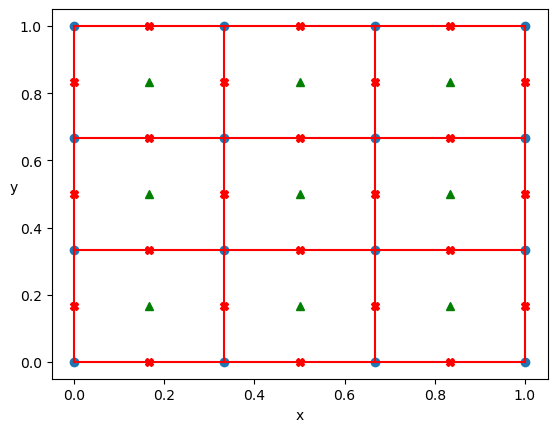

In [35]:
mesh = Mesh(3, 3, [0, 1], [0, 1])
mesh.plot()

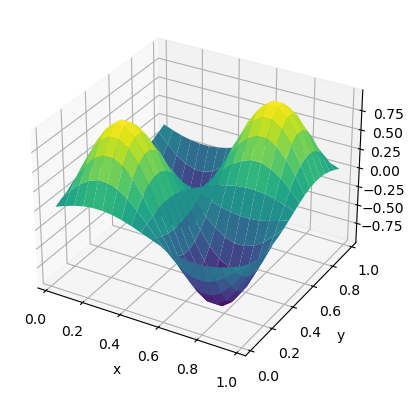

In [36]:
# initial condition

mesh = Mesh(20, 20, [0, 1], [0, 1])
p0 = np.array([np.sin(2.*np.pi*c.c.x/(mesh.Lx[1]-mesh.Lx[0]))*np.sin(2.*np.pi*c.c.y/(mesh.Ly[1]-mesh.Ly[0])) for c in mesh.c])
mesh.plot_field(p0)

In [37]:
def upwind(mesh, vel, p):
	F = np.zeros_like(mesh.f)
	for i in mesh.fi:
		f = mesh.f[i]
		u = np.dot(vel, f.n)
		F[i] = u*(u > 0)*p[f.cells[0]] + u*(u < 0)*p[f.cells[1]]
		F[i] *= f.area()
	return F

In [49]:
@dataclass
class PeriodicBC:
	f: list[Face]
	gc: list[int] = field(default_factory=list, init=False)

	def setup(self, mesh, criterion):
		self.gc = []
		for f in self.f:
			for i in mesh.fb:
				fp = mesh.f[i]
				if criterion(f, fp):
					self.gc.append(fp.cells[0])
					break



In [50]:
mesh = Mesh(3, 3, [0, 1], [0, 1])

bcl = PeriodicBC([mesh.f[i] for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]])
bcr = PeriodicBC([mesh.f[i] for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]])
bcb = PeriodicBC([mesh.f[i] for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0]])
bct = PeriodicBC([mesh.f[i] for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[1]])

bcl.setup(mesh, lambda f, fp: f.c.x != fp.c.x and f.c.y == fp.c.y)
bcr.setup(mesh, lambda f, fp: f.c.x != fp.c.x and f.c.y == fp.c.y)
bcb.setup(mesh, lambda f, fp: f.c.x == fp.c.x and f.c.y != fp.c.y)
bct.setup(mesh, lambda f, fp: f.c.x == fp.c.x and f.c.y != fp.c.y)

bcs = [bcl, bcr, bcb, bct]

In [324]:
# simulation

mesh = Mesh(20, 20, [0, 1], [0, 1])
p0 = np.array([np.sin(2.*np.pi*c.c.x/(mesh.Lx[1]-mesh.Lx[0]))*np.sin(2.*np.pi*c.c.y/(mesh.Ly[1]-mesh.Ly[0])) for c in mesh.c])
vel = np.array([1., 0.])

t, tf = 0, 0.1 
dt = 0.001
p = p0.copy()

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = upwind(mesh, vel, p)
	# F = periodic_upwind(F, u, p)
	# p = euler(F, f, c, p, dt)

	break

In [325]:
F

array([0, 0.0012235870926211607, 0.0035509880480051543,
       0.005530793552061857, 0.0069692064479381435, 0.007725424859373687,
       0.007725424859373685, 0.006969206447938141, 0.005530793552061858,
       0.0035509880480051517, 0.0012235870926211615,
       -0.0012235870926211598, -0.0035509880480051564,
       -0.005530793552061857, -0.006969206447938143,
       -0.007725424859373687, -0.007725424859373687,
       -0.0069692064479381435, -0.005530793552061859,
       -0.003550988048005155, 0, 0, 0.0035509880480051543,
       0.010305368692688173, 0.016050988048005154, 0.02022542485937369,
       0.022420056166685517, 0.022420056166685513, 0.020225424859373682,
       0.016050988048005154, 0.010305368692688166, 0.0035509880480051564,
       -0.003550988048005151, -0.01030536869268818, -0.016050988048005154,
       -0.020225424859373686, -0.02242005616668552, -0.022420056166685517,
       -0.02022542485937369, -0.016050988048005158, -0.010305368692688176,
       0, 0, 0.00553079355